In [65]:
import pandas as pd
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import geopandas as gpd
from geopy.distance import geodesic   

from collections import defaultdict
import time
import seaborn as sns
from weighted_graph import WeightedGraph

# Funções auxiliares


In [3]:
def read_polygon(filename, comma_separated=False, invert_x_y=False, close_polygon=True):
    xs = []
    ys = []
    with open(filename) as f:
        for line in f:
            stripped_line = line.strip()
            if len(stripped_line) == 0:
                continue
            if "," in line:
                x, y = [float(value) for value in line.split(",")]
            else:
                x, y = [float(value) for value in line.split()]
            xs.append(x)
            ys.append(y)

    if close_polygon and (xs[0] != xs[-1] or ys[0] != ys[-1]):
        xs.append(xs[0])
        ys.append(ys[0])

    if invert_x_y:
        return ys, xs
    else:
        return xs, ys


In [4]:
def plot_path(path, df_airports, ax):
    xs = []
    ys= []
    names = []
    for airport in path:
        row = df_airports[df_airports.id == airport].iloc[0]
        lon = row["lon"]
        lat = row["lat"]
        # x, y = utm.from_latlon(lat, lon)[:2]
        x, y = lon, lat
        xs.append(x)
        ys.append(y)
        names.append(row["city"])

    # Plot xs and ys with arrows indicating the direction
    ax.plot(xs, ys, marker='o', lw=0)
    for i in range(len(xs)-1):
        ax.annotate("", xy=(xs[i+1], ys[i+1]), xytext=(xs[i], ys[i]), arrowprops=dict(arrowstyle="->"), color='r')


    return xs, ys, names

# Construindo Dataframe dos aeroportos

In [74]:
columns = ["Aeroporto.Origem", "Cidade.Origem", "Pais.Origem", "Aeroporto.Destino", "Cidade.Destino", "Pais.Destino", "LatOrig", "LongOrig", "LatDest", "LongDest", "Duracao"]
group_columns = columns[:6]

In [118]:
df = pd.read_csv('BrFlights2.csv', encoding='latin1')

# Exchange latitude and longitude on Guiana
df_guiana = df[(df["Pais.Destino"] == "Guiana")]
lat = df_guiana["LatDest"]
df.loc[df["Pais.Destino"] == "Guiana", "LatDest"] = df_guiana["LongDest"]
df.loc[df["Pais.Destino"] == "Guiana", "LongDest"] = lat

df_guiana = df[(df["Pais.Origem"] == "Guiana")]
lat = df_guiana["LatOrig"]
df.loc[df["Pais.Origem"] == "Guiana", "LatOrig"] = df_guiana["LongOrig"]
df.loc[df["Pais.Origem"] == "Guiana", "LongOrig"] = lat

# Removendo cidada Buenos Aires/Aeroparque
df.loc[df["Cidade.Origem"] == "Buenos Aires/Aeroparque", "Cidade.Origem"] = "Buenos Aires"
df.loc[df["Cidade.Destino"] == "Buenos Aires/Aeroparque", "Cidade.Destino"] = "Buenos Aires"
df["Partida.Real"] = pd.to_datetime(df["Partida.Real"], format="%Y-%m-%dT%H:%M:%SZ")
df["Chegada.Real"] = pd.to_datetime(df["Chegada.Real"], format="%Y-%m-%dT%H:%M:%SZ")
df["Duracao"] = df["Chegada.Real"] - df["Partida.Real"]

# Convert duracao to hours
df["Duracao"] = df["Duracao"].apply(lambda x: x.total_seconds() / 3600)

In [124]:
df.columns

Index(['Voos', 'Companhia.Aerea', 'Codigo.Tipo.Linha', 'Partida.Prevista',
       'Partida.Real', 'Chegada.Prevista', 'Chegada.Real', 'Situacao.Voo',
       'Codigo.Justificativa', 'Aeroporto.Origem', 'Cidade.Origem',
       'Estado.Origem', 'Pais.Origem', 'Aeroporto.Destino', 'Cidade.Destino',
       'Estado.Destino', 'Pais.Destino', 'LongDest', 'LatDest', 'LongOrig',
       'LatOrig', 'Duracao'],
      dtype='object')

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

<Axes: xlabel='Duracao', ylabel='Count'>

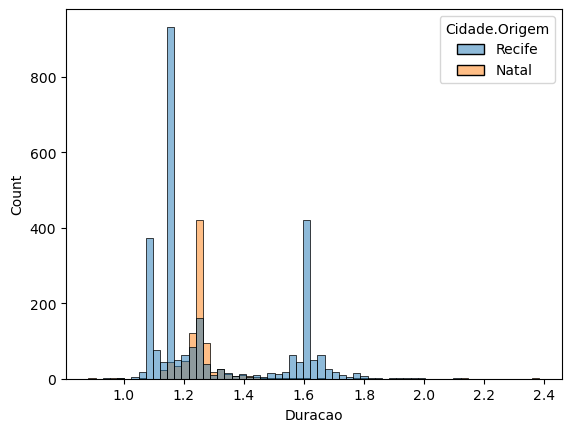

In [130]:
fig, ax = plt.subplots(figsize=(7, 7))
sns.histplot(data=df[(df["Cidade.Destino"] == "Fernando De Noronha") & (df["Duracao"] > 0)], x="Duracao", hue="Cidade.Origem", ax=ax)
plt.savefig("histograma_fernando_noronha.pdf", bbox_inches='tight')
plt.show()

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

<Axes: xlabel='Duracao', ylabel='Count'>

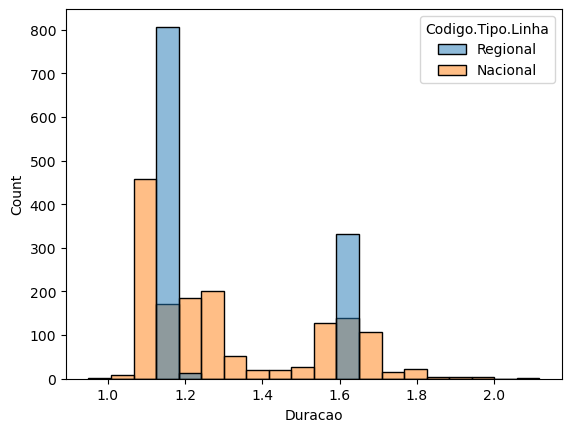

In [132]:

sns.histplot(data=df[(df["Cidade.Destino"] == "Fernando De Noronha") & (df["Duracao"] > 0) & (df["Cidade.Origem"] == "Recife")], x="Duracao", hue="Codigo.Tipo.Linha")

In [131]:
df.columns

Index(['Voos', 'Companhia.Aerea', 'Codigo.Tipo.Linha', 'Partida.Prevista',
       'Partida.Real', 'Chegada.Prevista', 'Chegada.Real', 'Situacao.Voo',
       'Codigo.Justificativa', 'Aeroporto.Origem', 'Cidade.Origem',
       'Estado.Origem', 'Pais.Origem', 'Aeroporto.Destino', 'Cidade.Destino',
       'Estado.Destino', 'Pais.Destino', 'LongDest', 'LatDest', 'LongOrig',
       'LatOrig', 'Duracao'],
      dtype='object')

In [122]:
df[(df["Cidade.Origem"]== "Recife") & (df["Cidade.Destino"] == "Fernando De Noronha")]
df[(df["Cidade.Origem"]== "Natal") & (df["Cidade.Destino"] == "Fernando De Noronha")]

,Voos,Companhia.Aerea,Codigo.Tipo.Linha,Partida.Prevista,Partida.Real,Chegada.Prevista,Chegada.Real,Situacao.Voo,Codigo.Justificativa,Aeroporto.Origem,...,Pais.Origem,Aeroporto.Destino,Cidade.Destino,Estado.Destino,Pais.Destino,LongDest,LatDest,LongOrig,LatOrig,Duracao
8763,AZU - 2731,AZUL,Nacional,2016-01-27T10:48:00Z,2016-01-27 10:39:00,2016-01-27T12:03:00Z,2016-01-27 11:57:00,Realizado,ANTECIPACAO DE HORARIO AUTORIZADA,Governador Aluizio Alves,...,Brasil,Fernando De Noronha,Fernando De Noronha,PE,Brasil,-32.424385,-3.854614,-35.367382,-5.76837,1.300000
8765,AZU - 2731,AZUL,Nacional,2016-01-16T10:48:00Z,2016-01-16 10:44:00,2016-01-16T12:03:00Z,2016-01-16 11:54:00,Realizado,ANTECIPACAO DE HORARIO AUTORIZADA,Governador Aluizio Alves,...,Brasil,Fernando De Noronha,Fernando De Noronha,PE,Brasil,-32.424385,-3.854614,-35.367382,-5.76837,1.166667
8766,AZU - 2731,AZUL,Nacional,2016-01-06T10:48:00Z,2016-01-06 10:40:00,2016-01-06T12:03:00Z,2016-01-06 11:51:00,Realizado,ANTECIPACAO DE HORARIO AUTORIZADA,Governador Aluizio Alves,...,Brasil,Fernando De Noronha,Fernando De Noronha,PE,Brasil,-32.424385,-3.854614,-35.367382,-5.76837,1.183333
8767,AZU - 2731,AZUL,Regional,2016-01-14T10:48:00Z,2016-01-14 10:48:00,2016-01-14T12:03:00Z,2016-01-14 12:03:00,Realizado,NaN,Governador Aluizio Alves,...,Brasil,Fernando De Noronha,Fernando De Noronha,PE,Brasil,-32.424385,-3.854614,-35.367382,-5.76837,1.250000
8769,AZU - 2731,AZUL,Regional,2016-01-05T10:48:00Z,2016-01-05 10:48:00,2016-01-05T12:03:00Z,2016-01-05 12:03:00,Realizado,NaN,Governador Aluizio Alves,...,Brasil,Fernando De Noronha,Fernando De Noronha,PE,Brasil,-32.424385,-3.854614,-35.367382,-5.76837,1.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2447371,AZU - 2731,AZUL,Regional,2015-12-14T10:48:00Z,2015-12-14 10:48:00,2015-12-14T12:03:00Z,2015-12-14 12:03:00,Realizado,NaN,Governador Aluizio Alves,...,Brasil,Fernando De Noronha,Fernando De Noronha,PE,Brasil,-32.424385,-3.854614,-35.367382,-5.76837,1.250000
2449987,AZU - 2960,AZUL,Nacional,2015-12-13T10:52:00Z,2015-12-13 10:43:00,2015-12-13T12:00:00Z,2015-12-13 11:58:00,Realizado,ANTECIPACAO DE HORARIO AUTORIZADA,Governador Aluizio Alves,...,Brasil,Fernando De Noronha,Fernando De Noronha,PE,Brasil,-32.424385,-3.854614,-35.367382,-5.76837,1.250000
2449988,AZU - 2960,AZUL,Regional,2015-12-20T10:52:00Z,2015-12-20 10:52:00,2015-12-20T12:00:00Z,2015-12-20 12:00:00,Realizado,NaN,Governador Aluizio Alves,...,Brasil,Fernando De Noronha,Fernando De Noronha,PE,Brasil,-32.424385,-3.854614,-35.367382,-5.76837,1.133333
2449989,AZU - 2960,AZUL,Regional,2015-12-27T10:52:00Z,2015-12-27 10:52:00,2015-12-27T12:00:00Z,2015-12-27 12:00:00,Realizado,NaN,Governador Aluizio Alves,...,Brasil,Fernando De Noronha,Fernando De Noronha,PE,Brasil,-32.424385,-3.854614,-35.367382,-5.76837,1.133333


In [82]:
df_inverted = df.copy()
df_inverted["Aeroporto.Origem"] = df["Aeroporto.Destino"]
df_inverted["Cidade.Origem"] = df["Cidade.Destino"]
df_inverted["Pais.Origem"] = df["Pais.Destino"]
df_inverted["Aeroporto.Destino"] = df["Aeroporto.Origem"]
df_inverted["Cidade.Destino"] = df["Cidade.Origem"]
df_inverted["Pais.Destino"] = df["Pais.Origem"]
df_inverted["LatOrig"] = df["LatDest"]
df_inverted["LongOrig"] = df["LongDest"]
df_inverted["LatDest"] = df["LatOrig"]
df_inverted["LongDest"] = df["LongOrig"]

df = pd.concat([df, df_inverted])

del df_inverted


In [83]:
df = df[df["Duracao"] > 0]
df = df[df["Situacao.Voo"] != "Cancelado"]
df = df[columns]



In [84]:
# Convert Partida.Real to datetime
df[(df["Cidade.Origem"] == "Rio De Janeiro") & (df["Cidade.Destino"] == "Fortaleza")]["Duracao"].describe()

count    12695.000000
mean         3.302735
std          2.859285
min          1.266667
25%          3.166667
50%          3.233333
75%          3.283333
max        123.233333
Name: Duracao, dtype: float64

In [86]:
df_group = df[columns].groupby(group_columns).median().reset_index()
def distance(point0, point1):
    return geodesic(point0, point1).km

distancias = []
for row in df_group.itertuples():
    point0 = (row.LatOrig, row.LongOrig)
    point1 = (row.LatDest, row.LongDest)
    distancias.append(distance(point0, point1))

df_group["Distancia"] = distancias
df_group.to_csv("BrFlights2_group_guiana_corrected.csv", index=False)
del df

In [87]:
df_group = pd.read_csv('BrFlights2_group_guiana_corrected.csv')


In [107]:
domain = "world"
domain = "brasil"

df_group = df_group[(df_group["Pais.Destino"] == "Brasil") & (df_group["Pais.Origem"] == "Brasil")]

In [108]:
df_group[(df_group["Cidade.Origem"] == "Rio De Janeiro") & (df_group["Cidade.Destino"] == "Fortaleza")]["Distancia"].describe()


count       1.00000
mean     2166.67464
std             NaN
min      2166.67464
25%      2166.67464
50%      2166.67464
75%      2166.67464
max      2166.67464
Name: Distancia, dtype: float64

In [109]:
# Load the world map data from Natural Earth
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

In [110]:
airports2id = {}
id2airports = {}
id = 0

for i, row in df_group.iterrows():
    aer01 = row["Aeroporto.Origem"]
    if aer01 not in airports2id:
        airports2id[aer01] = id
        id2airports[id] = aer01
        id += 1

    aer02 = row["Aeroporto.Destino"]
    if aer02 not in airports2id:
        airports2id[aer02] = id
        id2airports[id] = aer02
        id += 1

airports = {}
for row in df_group.iterrows():
    name = row[1]["Aeroporto.Origem"]
    if name not in airports:
        airports[name] = {
            "name": name,
            "country": row[1]["Pais.Origem"],
            "city": row[1]["Cidade.Origem"],
            "lat": row[1]["LatOrig"],
            "lon": row[1]["LongOrig"],
            "id": airports2id[name]}
        id+=1
    name = row[1]["Aeroporto.Destino"]
    if name not in airports:
        airports[name] = {
            "name": name,
            "country": row[1]["Pais.Destino"],
            "city": row[1]["Cidade.Destino"],
            "lat": row[1]["LatDest"],
            "lon": row[1]["LongDest"], 
            "id": airports2id[name]}
        id+=1

df_airports = pd.DataFrame.from_dict(airports, orient='index').reset_index()
df_airports.set_index("id", inplace=True)

In [111]:
g_time = WeightedGraph(len(airports2id))

for row in df_group.iterrows():
    id0 = airports2id[row[1]["Aeroporto.Origem"]]
    id1 = airports2id[row[1]["Aeroporto.Destino"]]
    duration = row[1]["Duracao"]
    g_time.add_edge(id0, id1, duration, check=True)

g_distance = WeightedGraph(len(airports2id))

for row in df_group.iterrows():
    id0 = airports2id[row[1]["Aeroporto.Origem"]]
    id1 = airports2id[row[1]["Aeroporto.Destino"]]
    distance_km = row[1]["Distancia"]
    g_distance.add_edge(id0, id1, distance_km, check=True)
    
    

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


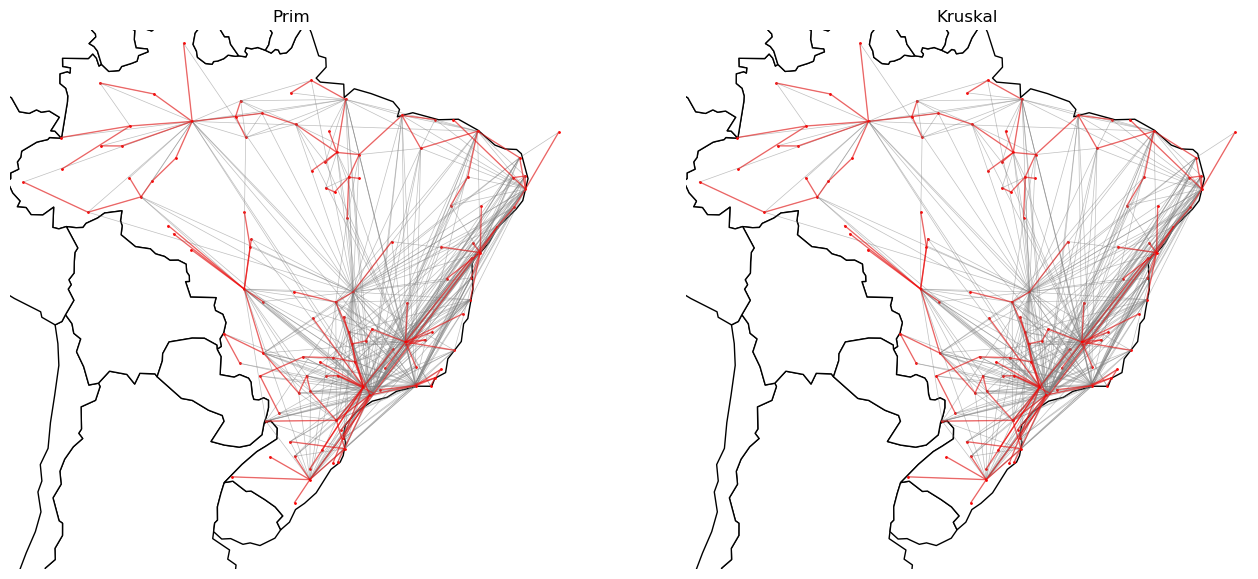

In [112]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

world.plot(ax=axs[0], color='white', edgecolor='black')
world.plot(ax=axs[1], color='white', edgecolor='black')

axs[0].plot(df_airports.lon, df_airports.lat, marker='o', lw=0, color='r', markersize=1)
axs[1].plot(df_airports.lon, df_airports.lat, marker='o', lw=0, color='r', markersize=1)

axs[0].set_title("Prim")
axs[1].set_title("Kruskal")

xmin, xmax = df_airports.lon.min(), df_airports.lon.max()
ymin, ymax = df_airports.lat.min(), df_airports.lat.max()

for ax in axs.flat:
    ax.set_xlim(xmin-1, xmax+1)
    ax.set_ylim(ymin-5, ymax+1)
    ax.set_axis_off()


for edge in g_time.edges_list:
    weight, id0, id1 = edge
    axs[0].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='gray', lw=0.5, alpha=0.5)
    axs[1].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='gray', lw=0.5, alpha=0.5)

plt.savefig(f"tex/figs/{domain}_time_mst_0.pdf")

mst_prim = g_time.prim_lazy()
for edge in mst_prim.edges_list:
    weight, id0, id1=edge
    axs[0].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='r', lw=1.0, alpha=0.5)

mst_kruskal = g_time.kruskal()
for edge in mst_kruskal.edges_list:
    weight, id0, id1=edge
    axs[1].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='r', lw=1.0, alpha=0.5)

plt.savefig(f"tex/figs/{domain}_time_mst_1.pdf")
plt.show()

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


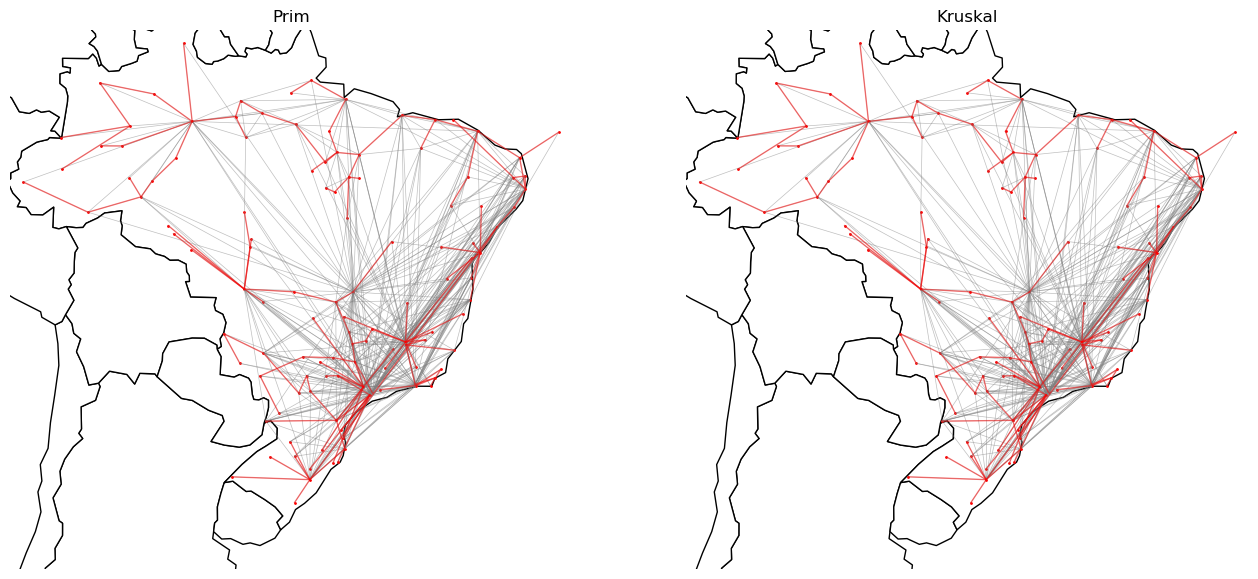

In [113]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

world.plot(ax=axs[0], color='white', edgecolor='black')
world.plot(ax=axs[1], color='white', edgecolor='black')

axs[0].plot(df_airports.lon, df_airports.lat, marker='o', lw=0, color='r', markersize=1)
axs[1].plot(df_airports.lon, df_airports.lat, marker='o', lw=0, color='r', markersize=1)

axs[0].set_title("Prim")
axs[1].set_title("Kruskal")

xmin, xmax = df_airports.lon.min(), df_airports.lon.max()
ymin, ymax = df_airports.lat.min(), df_airports.lat.max()

for ax in axs.flat:
    ax.set_xlim(xmin-1, xmax+1)
    ax.set_ylim(ymin-5, ymax+1)
    ax.set_axis_off()


for edge in g_distance.edges_list:
    weight, id0, id1 = edge
    axs[0].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='gray', lw=0.5, alpha=0.5)
    axs[1].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='gray', lw=0.5, alpha=0.5)

plt.savefig(f"tex/figs/{domain}_distance_mst_0.pdf")

mst_prim = g_distance.prim_lazy()
for edge in mst_prim.edges_list:
    weight, id0, id1=edge
    axs[0].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='r', lw=1.0, alpha=0.5)

mst_kruskal = g_distance.kruskal()
for edge in mst_kruskal.edges_list:
    weight, id0, id1=edge
    axs[1].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='r', lw=1.0, alpha=0.5)

plt.savefig(f"tex/figs/{domain}_distance_mst_1.pdf")
plt.show()

/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/mateusoliveira/Algoritmos/.conda/lib/python3.10/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


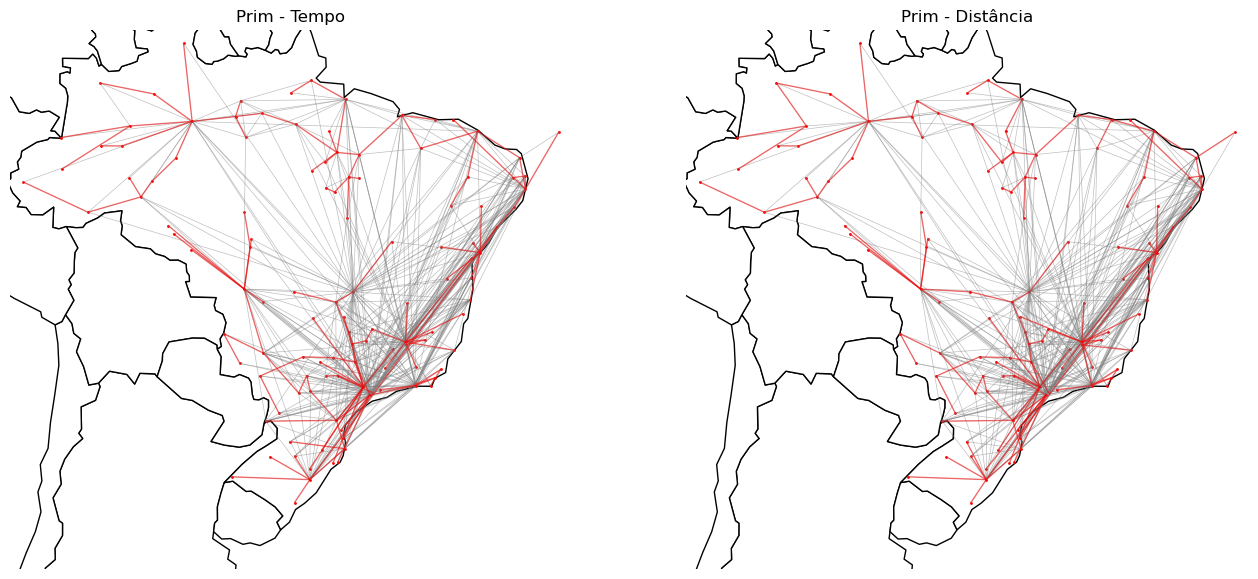

In [114]:
fig, axs = plt.subplots(1, 2, figsize=(16, 7))

world.plot(ax=axs[0], color='white', edgecolor='black')
world.plot(ax=axs[1], color='white', edgecolor='black')

axs[0].plot(df_airports.lon, df_airports.lat, marker='o', lw=0, color='r', markersize=1)
axs[1].plot(df_airports.lon, df_airports.lat, marker='o', lw=0, color='r', markersize=1)

axs[0].set_title("Prim - Tempo")
axs[1].set_title("Prim - Distância")

xmin, xmax = df_airports.lon.min(), df_airports.lon.max()
ymin, ymax = df_airports.lat.min(), df_airports.lat.max()

for ax in axs.flat:
    ax.set_xlim(xmin-1, xmax+1)
    ax.set_ylim(ymin-5, ymax+1)
    ax.set_axis_off()


for edge in g_distance.edges_list:
    weight, id0, id1 = edge
    axs[0].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='gray', lw=0.5, alpha=0.5)
    axs[1].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='gray', lw=0.5, alpha=0.5)


mst_prim = g_time.prim_lazy()
for edge in mst_prim.edges_list:
    weight, id0, id1 = edge
    axs[0].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='r', lw=1.0, alpha=0.5)

mst_prim_dist = g_distance.kruskal()
for edge in mst_prim_dist.edges_list:
    weight, id0, id1=edge
    axs[1].plot([df_airports.loc[id0].lon, df_airports.loc[id1].lon], [df_airports.loc[id0].lat, df_airports.loc[id1].lat], color='r', lw=1.0, alpha=0.5)

plt.savefig(f"tex/figs/{domain}_time_x_distance_mst_1.pdf")
plt.show()

<Axes: xlabel='Duracao', ylabel='Distancia'>

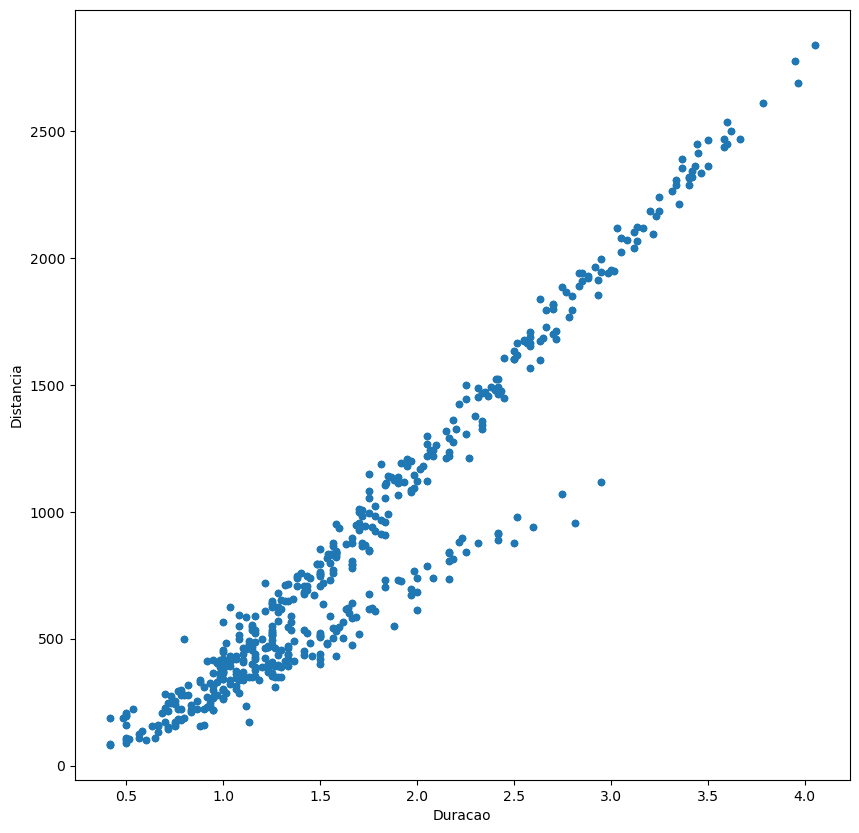

In [117]:
df_group.plot(x="Duracao", y="Distancia", kind="scatter", figsize=(10, 10))

In [116]:
max = -float("inf")
max_ind = None
for i, neighbours in enumerate(mst_prim.adj):
    if len(neighbours) > max:
        max = len(neighbours)
        max_ind = i

print(max_ind, id2airports[max_ind])

4 Viracopos
